# News Headlines Dataset For Sarcasm Detection using Tensorflow

* The main idea is to create a Tensorflow NLP model to do binary classification from Tweets.
* Good source of read [Representing text in NLP](https://towardsdatascience.com/representing-text-in-natural-language-processing-1eead30e57d8).
* And we choose GloVe embedding model in this case.

### Reading the data
* Following code snippet could be used to read the data:

      import json
      def parse_data(file):
        for l in open(file,'r'):
        yield json.loads(l)
      data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))  

### Citation
* Please link to rishabhmisra.github.io/publications in your report if you're using this dataset.
* If you're using this dataset for research purposes, please use the following BibTex for citation:

      @article{misra2019sarcasm,
      title={Sarcasm Detection using Hybrid Neural Network},
      author={Misra, Rishabh and Arora, Prahal},
      journal={arXiv preprint arXiv:1908.07414},
      year={2019}
    }


# Aim of the Task and Steps to Achieve

* Exploratory Data Analysis
    * Check whether the target/label is balanced.
    * Remove noise from the text: stopwords, puntuation and brackets.
    * Explore number of characters/text etc per sentence (To see if one label has biased result than the other).

* Data Preprocessing:
    * **Tokenize** the words; Convert unique words to a language which can be recongnised by a machine: number.
    * Combine the tokens to a sentence which have different length: I love you: [1, 2,3], and store into a **numpy list**.
    * Apply padding to the sentence; add the zeros at the start/end of the sequence to make the samples in the **same** size.

* GloVe Embedding as one of the network layers:
    * GloVe stands for **GloVe: Global Vectors for Word Representation**, as an extension of word2vec, by Pennington, et al. at Stanford.
    * **Embedding** means to define a word by counting the others words occur/appear in the same environment (kind of a clustering), for example: plant/machine/build.
    * **Word Embedding**: If instead of counting how often each word w occurs in the context of another word v, we instead train a classifier on a binary prediction task “Is word w likely to show up near v?”, then we can used the learned classifier weights as the word embeddings. A learned representation for text where words that have the same meaning have a similar representation.
    <blockquote>Instead of extracting the embeddings from a neural network or a logistic regression that is designed to perform a classification task (predicting neighbouring words), GloVe optimizes the embeddings directly so that the dot product of two word vectors equals the log of the number of times the two words will occur near each other (within a 2-words window, for example). This forces the embeddings vectors to encode the frequency distribution of which words occur near them.</blockquote>
    * From [GitHub](https://github.com/stanfordnlp/GloVe), we would use [Twitter GloVe(glove.twitter.27B.zip)](https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip) which contains 2B tweets, 27B tokens, 1.2M vocab, uncased, 200d vectors, 1.42 GB download.
    ```import zipfile
    with zipfile.ZipFile('glove.twitter.27B.zip', 'r') as zip_ref:
    zip_ref.extractall('C:\\Users\\user\\Documents\\nlp_sarcasm')
    
    
* Check training and validation accuracy and losses across epoch.
* Confusion Matrix and Model Summary
    
    

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils as ku 
from sklearn.metrics import classification_report
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import csv
import random
import numpy as np
from bs4 import BeautifulSoup
import re,string,unicodedata
from string import punctuation
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns

In [31]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.run_functions_eagerly(True)

In [32]:
%reload_ext watermark
%watermark -v -p numpy,pandas,tensorflow,sklearn,keras,transformers

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

numpy       : 1.19.5
pandas      : 1.2.1
tensorflow  : 2.4.1
sklearn     : 0.0
keras       : 2.4.3
transformers: 4.3.2



In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True) # Load the data
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

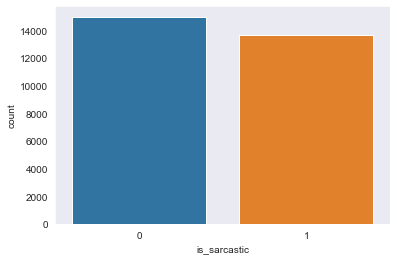

In [6]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

<ipython-input-10-39a5bb31d836>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.append(fig.add_subplot(1, 2, 1))


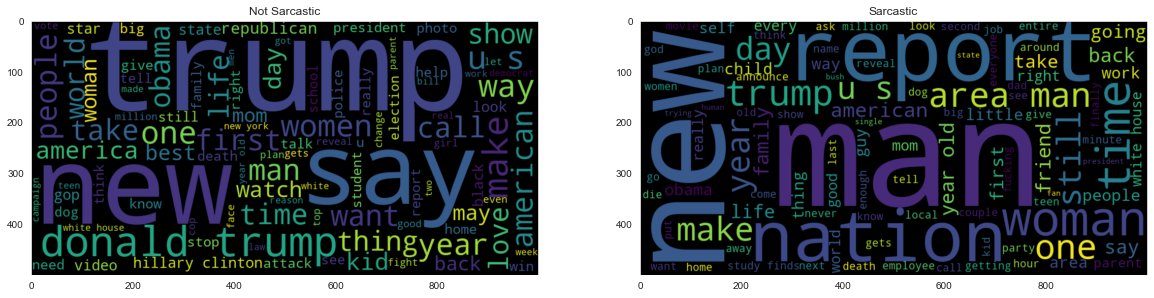

In [10]:
# ax enables access to manipulate each of subplots
ax = []

fig=plt.figure(figsize=(20, 20))
wc_not_sarcastic = WordCloud(max_words = 100 , width = 1000 , height = 500).generate(" ".join(df[df.is_sarcastic == 0].headline))
wc_sarcastic     = WordCloud(max_words = 100 , width = 1000 , height = 500).generate(" ".join(df[df.is_sarcastic == 1].headline))

fig.add_subplot(1, 2, 1)
ax.append(fig.add_subplot(1, 2, 1))
ax[-1].set_title("Not Sarcastic")
plt.imshow(wc_not_sarcastic , interpolation = 'bilinear')

ax.append(fig.add_subplot(1, 2, 2))
ax[-1].set_title("Sarcastic")
plt.imshow(wc_sarcastic , interpolation = 'bilinear')

plt.show()

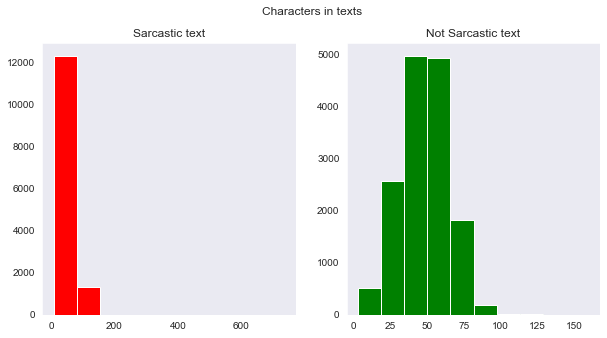

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

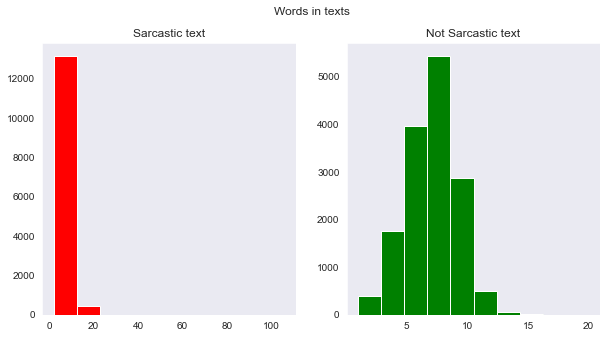

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

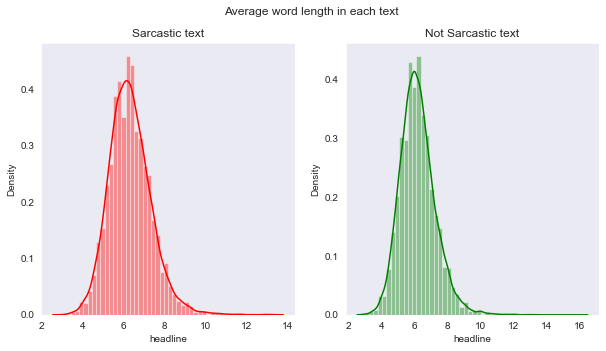

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10, 5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [14]:
embedding_dim = 200
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = len(df.index)
test_portion=.1

corpus = []
num_sentences = 0

for i in range(0, len(df.index), 1):
    list_item = []
    list_item.append(df.headline.values[i])
    this_label = df.is_sarcastic.iloc[i]
    if this_label == 0:
        list_item.append(0)
    else:
        list_item.append(1)
    num_sentences = num_sentences + 1
    corpus.append(list_item)
   

In [15]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

28619
28619
['dem rep. totally nails congress falling short gender, racial equality', 0]


In [16]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# A dictionary storing 30819 of {string: numerical value representation}
word_index = tokenizer.word_index
vocab_size=len(word_index)

# A list storing tokenized words without padding
sequences = tokenizer.texts_to_sequences(sentences)

# A list storing tokenized and padded words
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]


training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

In [17]:
print(vocab_size)
print(word_index['i'])

30819
1909


In [18]:
embeddings_index = {};
with open('glove.twitter.27B.200d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

# Define Tensorflow Model with
    * GloVe embedding layer
    * Bidirectional LSTM for words
    * Output

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(LSTM(150, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(vocab_size/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           6164000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 300)           421200    
_________________________________________________________________
dropout (Dropout)            (None, 20, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 15409)             1556309   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15410     
Total params: 8,317,319
Trainable params: 2,153,319
Non-trainable params: 6,164,000
______________________________________

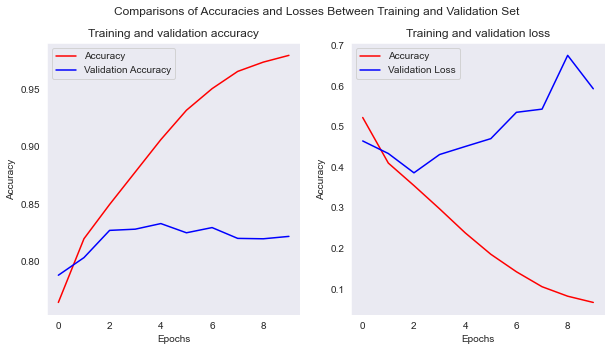

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(epochs, acc, 'r')
ax1.plot(epochs, val_acc, 'b')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Accuracy", "Validation Accuracy"])

ax2.plot(epochs, loss, 'r')
ax2.plot(epochs, val_loss, 'b')
ax2.set_title('Training and validation loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(["Accuracy", "Validation Loss"])

fig.suptitle('Comparisons of Accuracies and Losses Between Training and Validation Set')
plt.show()

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           6164000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 64)            64064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,261,153
Trainable params: 97,153
Non-trainable params: 6,164,000
_______________________________________

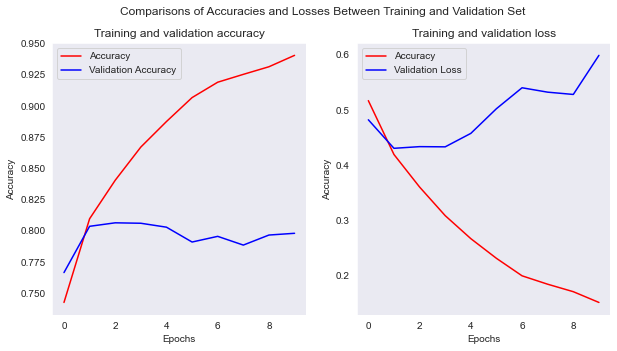

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(epochs, acc, 'r')
ax1.plot(epochs, val_acc, 'b')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Accuracy", "Validation Accuracy"])

ax2.plot(epochs, loss, 'r')
ax2.plot(epochs, val_loss, 'b')
ax2.set_title('Training and validation loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(["Accuracy", "Validation Loss"])

fig.suptitle('Comparisons of Accuracies and Losses Between Training and Validation Set')
plt.show()

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(LSTM(150, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 200)           6164000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 20, 300)           421200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 40)                12040     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)               

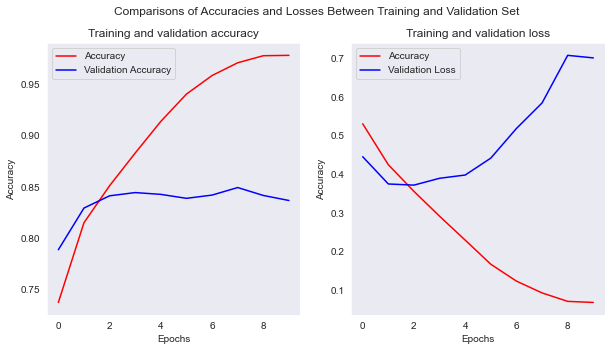

In [46]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(epochs, acc, 'r')
ax1.plot(epochs, val_acc, 'b')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Accuracy", "Validation Accuracy"])

ax2.plot(epochs, loss, 'r')
ax2.plot(epochs, val_loss, 'b')
ax2.set_title('Training and validation loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(["Accuracy", "Validation Loss"])

fig.suptitle('Comparisons of Accuracies and Losses Between Training and Validation Set')
plt.show()

In [51]:
pred = model.predict_classes(testing_padded)
print(classification_report(testing_labels, pred, target_names = ['Not Sarcastic','Sarcastic']))

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


               precision    recall  f1-score   support

Not Sarcastic       0.86      0.82      0.84      1482
    Sarcastic       0.81      0.86      0.83      1379

     accuracy                           0.84      2861
    macro avg       0.84      0.84      0.84      2861
 weighted avg       0.84      0.84      0.84      2861



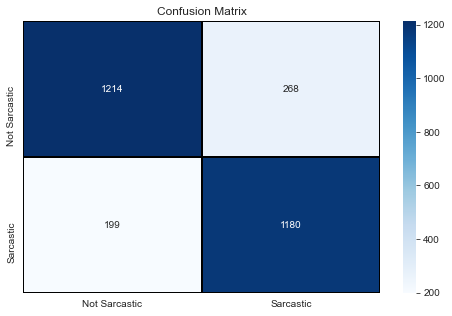

In [52]:
cm = pd.DataFrame(confusion_matrix(testing_labels, pred) , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (8,5))

ax = plt.axes()
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'], ax = ax)
ax.set_title('Confusion Matrix')
plt.show()

In [56]:
print('Accuracy of Final GloVe + LSTM Model on test set: {:.2%}'
     .format(accuracy_score(testing_labels, pred)))

Accuracy of Final GloVe + LSTM Model on test set: 83.68%


# Some Conclusions

* Since we are training a balanced dataset for classifcation problem, the model is proven having **no bias** by looking at confusion matrix.
* The accuracy of training dataset is increasing over epoch, but validation stays.
* The loss of training dateset is decreasing over epoch, but validation increases over time.
* This indicates an **overfitting** case.
* However, the accuracy of the model is 83.68%, which is considered good enough.